In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
import dolfin as fe
from matplotlib import pyplot as plt
import numpy as np
import time
import matplotlib.animation as animation
import sys
import pandas as pd
from scipy import signal
import datetime

fe.set_log_level(30)

In [ ]:
#Global variables
d=50*1E-6 #Thickness of membrane (m)
dl=250*1E-6 #Thickness of boundary layer(m)
db=225*1E-6 #Thickness of bulk layer (m)
Im=4 #Number of partitions of length L
Cin=0.05 #Bulk concentration of NaCl (mol/l)
C0=Cin*1000 #Bulk concentration of NaCl (mol/m3)
k_C0=(6.4849*Cin**2-36.855*Cin**(3/2)+71.035*Cin-81.379*Cin**(1/2)+126.45)*Cin/10 #conductivity of NaCl (S/m) (Mareev y Nikonenko 2012)
Cmem=0.12*1000 #Counter ion concentration in the membrane (mol/m3)
Cm=0.12 #Counter ion concentration in the membrane (mol/l)
#k_m=(6.4849*Cm**2-36.855*Cm**(3/2)+71.035*Cm-81.379*Cm**(1/2)+126.45)*Cm/10
#k_m=0.12
D=1.611E-9 #Diffusion coefficient of NaCl (m2/s) (Lide 2008)
T_Na_m=0.95 #Transport number of Na in membrane
T_Cl_m=0.05 #Transport number of Cl in membrane
T_Na_d=0.396 #Transport number of Na in solution
T_Cl_d=0.604 #Transport number of Cl in solution
z_Na=1 #Valence
z_Cl=-1 #Valence
F=96485.332 #Faraday constant (C/mol)
R=8.31446 #Gas constant (m3*Pa/K*mol) o (J/(K*mol))
Temp=25+273.15 #Temperature (K)
lcd=56.0 #limiting current density (A/m2)
W=R*Temp/F*(T_Na_d-T_Cl_d) #constant RT/F*(T_Na_d-T_Cl_d) (m3*Pa/C) --> (W/A) --> (V)
I=40 #Number of partitions of length dl (boundary layer), 36 for 20000 partitions, 23 for 8000
L=dl
dZ=L/I #Step size of length L
x=np.linspace(-dl,dl+d,2*I+Im+1) #position vector
Rm=1E-3 #membrane resistance ohm/m2

In [ ]:
#Time discretization and pulse definition
def ED_Model(t_on,t_rev,lcd_mod,rev_amp,tsim):

    iop=lcd_mod*lcd #Operational current density (A/m2)

    #Time discretization step
    dt=0.01
    while abs(np.round(t_on/dt) - t_on/dt)>1E-3 or abs(np.round(t_rev/dt) - t_rev/dt)>1E-3:
        if abs(np.round(t_on/(dt/2))-t_on/(dt/2))<1E-3 and abs(np.round(t_rev/(dt/2))-t_rev/(dt/2))<1E-3:
            dt=dt/2
        elif abs(np.round(t_on/(dt/5))-t_on/(dt/5))<1E-3 and abs(np.round(t_rev/(dt/5))-t_rev/(dt/5))<1E-3:
            dt=dt/5
        else:
            dt=dt/10

    dt_min=min(t_on,t_rev)/2
    if dt>dt_min and dt_min>0:
        dt=dt_min

    print("dt=",dt)
    N=int(np.ceil(tsim/dt)+1) #Number of partitions of time tf
    freq=1/(t_rev+t_on) #frequency
    ts=np.linspace(0,tsim,N)#Time vector

    #Pulsing Definition
    seg=signal.square(ts*2*np.pi*freq,duty=(t_on/(t_on+t_rev)))*iop
    for delta in range(len(seg)):
        if seg[delta]!=iop:
            seg[delta]=-iop*rev_amp

    k_on=t_on/dt #working polarity, transformed to steps
    k_rev=t_rev/dt #reverse polarity, transformed to steps
    try:
        period = (1/freq)
    except ZeroDivisionError:
        period = 0

    puls=seg

    puls[0] = 0

    return dt, puls, N, ts

In [ ]:
#Domain discretization function

#Left DBL domain discretization
def left_DBL_beta(beta_mesh, N, alfa):

    #Mesh definition
    mesh = np.ones(N)

    #Nodes definition
    for i in range(N):

        mesh[i] = 1 - ((N + 2 - i)/(N + 2))**beta_mesh

    return np.interp(mesh, (mesh.min(), mesh.max()), (-dl, 0 - alfa))

#Right DBL domain discretization
def right_DBL_beta(beta_mesh, N, alfa):

    #Mesh definition
    mesh = np.ones(N)

    #Nodes definition
    for i in range(N):

        mesh[i] = abs(((N + 2 - i)/(N + 2))**beta_mesh )

    return np.sort(np.interp(mesh, (mesh.min(), mesh.max()), (d + alfa, dl + d)))

#Mesh constants
beta_mesh = 1.3
alfa = 1*10E-9

In [ ]:
#Mesh definition
malla = np.zeros(2 * I + Im + 2)

mesh_1 = left_DBL_beta(beta_mesh, I, alfa)
mesh_2 = right_DBL_beta(beta_mesh, I, alfa)

#Mesh construction
for i in range(2 * I + Im + 2):

	if i < I:
	  malla[i] = mesh_1[i]

	elif i >= I and i < I + Im + 2:
	  malla[i] = (i - I)*d / Im

	else:
	  malla[i] = -1*mesh_1[i - (I + Im + 2)] + d

malla.sort()

In [ ]:
#Boundary and initial conditions definition

def right_boundary(x, on_boundary): #Right boundary condition
        return on_boundary and fe.near(x[0],dl +d)

class Boundary(fe.SubDomain): #Membrane boundary condition
    def inside(self, x, on_boundary):
        return x[0] > 0 and x[0] < d

def left_boundary(x, on_boundary): #Left boundary condition
		return on_boundary and fe.near(x[0],-dl)

class C_initial(fe.UserExpression): #Initial concentration
        def eval(self, value, x):
            if x[0] >= 0 and x[0] <= d:
                value[0] = C0
            else:
                value[0] = C0
        def value_shape(self):
            #return (1,)
            return()

#Transport number and gradient condition definition
class TNa(fe.UserExpression): #Transport number definition
        def eval(self, value, x):
            if x[0] >= 0 and x[0] <= d:
                value[0] = T_Na_m
            else:
                value[0] = T_Na_d
        def value_shape(self):
            #return (1,)
            return()

class Derivada_(fe.UserExpression): #Gradient condition definition
        def eval(self, value, x):
            if x[0] >= 0 and x[0] <= d:
            	value[0] = 0
            else:
            	value[0] = 1
        def value_shape(self):
            #return (1,)
            return()

#Double Diffusion Model

class TSds(fe.UserExpression): # Definimos los valores de TNa en el dominio
        def eval(self, value, x):
            if x[0] >= 0 and x[0] <= d:
                value[0] = 0
            else:
                value[0] = T_Cl_d
        def value_shape(self):
            #return (1,)
            return()


class TCl(fe.UserExpression): # Definimos los valores de TNa en el dominio
        def eval(self, value, x):
            if x[0] >= 0 and x[0] <= d:
                value[0] = T_Cl_m
            else:
                value[0] = T_Cl_d
        def value_shape(self):
            #return (1,)
            return()

def Boundary_SDS(x, on_boundary): # Definimos la condicion para la frontera izquierda
		return  d <= x[0] <=d+dl


In [ ]:
#Finite element method definition
def funcion_ram(t_on,t_rev,lcd_mod,rev_amp,tsim):

  Ener = 0 #Initial state of energy consumption

  C_min = np.zeros(2*I+Im+2) #Aux variable for min concentration

  C_diluate = [] #Aux variable for the diluate side

  ts = 0 #Initial Simulation time

  x = np.linspace(-dl,dl+d,2*I+Im+1) #Uniform mesh definition

  delta_t, puls, N, ts = ED_Model(t_on,t_rev,lcd_mod,rev_amp,tsim) #Δt, time simulation, number of iteration and puls definition

  malla = np.zeros(2 * I + Im + 2) #Aux variable for no uniform mesh definition

  #Diluate side mesh definition
  mesh_1 = left_DBL_beta(beta_mesh, I, alfa)

  #Concentrate side mesh definition
  mesh_2 = right_DBL_beta(beta_mesh, I, alfa)

  #No uniform mesh definition
  for i in range(2 * I + Im + 2):

    if i < I:
        malla[i] = mesh_1[i]

    elif i >= I and i < I + Im + 2:
        malla[i] = (i - I)*d / 4

    else:
        malla[i] = mesh_2[i - I - Im -2]

  malla.sort()

  n_elements = 2 * I + Im + 2 #Number of nodes

  mesh = fe.IntervalMesh(n_elements-1,-dl, d + dl) #FeniCS mesh definition

  x = np.linspace(-dl,dl+d,2*I+Im+1) #Postion vector

  mesh.coordinates()[:] = np.reshape(malla,(n_elements,1)) #No uniform reshaped mesh

  V = fe.FunctionSpace(mesh, 'CG', 1) #Function space

  boundary = Boundary() #Membrane boundary

  bc = fe.DirichletBC(V, fe.Constant(Cmem), boundary) #Membrane boundary condition

  BC1 = fe.DirichletBC(
    V,
    fe.Constant(C0),
    left_boundary
      ) #Diluate side boundary condition

  BC3 = fe.DirichletBC(
    V,
    fe.Constant(C0),
    right_boundary
      ) #Concentrate side boundary condition

  BCS = [BC1,BC3]	#Boundary conditions

  #Gradient condition definition
  deriv_ = fe.Function(V)
  deriv_.interpolate(Derivada_(degree = 2))

  #Transport number function definition
  T_i = fe.Function(V)
  T_i.interpolate(TNa(degree = 2))

  #Aux solution variable
  C_old = fe.Function(V)
  C_old.interpolate(C_initial(degree = 2))

  c_trial = fe.TrialFunction(V) #Trial function definition
  v_test = fe.TestFunction(V) #Test function definiton

  iop = puls[0] #First iteration puls

  g = fe.Expression('iop', iop = iop, degree = 1) #Aux puls function

  #Puls function definition
  i_t = fe.Function(V)
  i_t.interpolate(g)

  a = (
  + c_trial * v_test * fe.dx
  + deriv_ * delta_t * D * c_trial.dx(0) * v_test * fe.ds
  + deriv_ * delta_t * D * c_trial.dx(0) * v_test.dx(0) * fe.dx
  ) #Bilinear form

  L = (
  + C_old * v_test * fe.dx
  + delta_t * i_t * T_i * v_test.dx(0) / (z_Na * F) * fe.dx
  + delta_t * i_t * T_Na_d * v_test / (z_Na * F) * fe.ds
  ) #Linear form

  C_old.interpolate(C_initial(degree = 2)) #Initial condition interpolation

  #Mesh nodes
  xyz = V.tabulate_dof_coordinates()
  x = xyz[:,0]


  c_solution = fe.Function(V) #Aux solution function

  time_current = 0 #Initial time

  A = fe.assemble(a) #Assemble bilinear form
  [bc.apply(A) for bc in BCS]
  solver = fe.LUSolver(A) #Solver definition

  indices = []

  C_Na = np.zeros([2*I+Im+2,N-1]) #Concentration function variable

  #Membrane mesh nodes
  for i in range(len(x)):

    if x[i] > 0 and x[i] < d:

      indices.append(i)

  dV_tot = 0 #Initial differential potential

  dt = delta_t #Time step definition

  for n in range(0,N-1):

    iop = puls[n] #Puls value for instant n

    #Puls function
    g = fe.Expression('iop', iop = iop, degree = 1)
    i_t.interpolate(g)

    # Assemble the right hand side
    b = fe.assemble(L)

    [bc.apply(b) for bc in BCS] #Apply boundary condition

    solver.solve(c_solution.vector(),b) #Apply solver

    C_old.assign(c_solution) #Assign previous step solution

    #Assign membrane concentarion values
    for j in indices:
      c_solution.vector()[j] = Cmem

    C_Na[:,n] = c_solution.vector().get_local() / 1000 #Get concentration values for the mesh

    #Concentration solution after 200s of simulation
    if round(200/delta_t) == n:
      C_min = C_Na[:,n] * 1000

    time_current += delta_t #Update current time

    #Save important concentration values
    if n % int((1/delta_t)) == 0:
      C_diluate.append(C_Na[:,n][indices[-1]+1]*1000)
      #print("Paso: ", int(time_current))

    k_C = np.zeros(2*I+Im+2) #Conductivity function definition

    #Conductivity function approximation
    k_C =(6.4849*C_Na[:,n]**2-36.855*C_Na[:,n]**(3/2)+71.035*C_Na[:,n]-81.379*C_Na[:,n]**(1/2)+126.45)*C_Na[:,n]/10 #(S/m)

    dV = 0 #Intial voltage drop

    #DBL voltage drop approximation
    for i in range(indices[-1]+1,2*I+Im+1):

        dZ = malla[i]- malla[i-1]
        if (k_C[i]==k_C[i-1]):
            dv=puls[n]*dZ/k_C[i]
        else:
            dv=+(puls[n]*dZ*(np.log(k_C[i]/k_C[i-1]))/(k_C[i]-k_C[i-1]))+W*(np.log(C_Na[i,n]/C_Na[i-1,n]))

        dV += dv

    for i in range(indices[-1]-3,-1,-1): #diluate side

        dZ = malla[i+1]- malla[i]
        if (k_C[i]==k_C[i+1]):
            dv=puls[n]*dZ/k_C[i]
        else:
            dv=+(puls[n]*dZ*(np.log(k_C[i+1]/k_C[i]))/(k_C[i+1]-k_C[i]))+W*(np.log(C_Na[i+1,n]/C_Na[i,n]))

        dV += dv

    dV_bulk_d=puls[n]*db/k_C0 #Right Bulk voltage drop

    dV_bulk_c=puls[n]*db/k_C0 #Left Bulk voltage drop

    dV_mem=puls[n]*Rm #Membrane voltage drop

    #System voltage drop approximation
    if n == 0:
      dv_tot_1 = (dV_bulk_d + dV_mem + dV_bulk_c + dV) * puls[n]

    elif n == N-2:

      dv_tot_N = (dV_bulk_d + dV_mem + dV_bulk_c + dV) * puls[n]


    else:

      dV_tot += (dV_bulk_d + dV_mem + dV_bulk_c + dV)* puls[n]

  Ener=(0.5*(dv_tot_1+dv_tot_N)+dV_tot)*dt #Energy consumption approximation

  print(np.round(Ener,0)/1000)

  return Ener, C_min, C_diluate, ts, x

In [ ]:
#Brief results function
def dt_print(t_on,t_rev,lcd_mod,rev_amp,tsim):

    iop=lcd_mod*lcd #Operational current density (A/m2)

    #pulsing definition
    dt=0.01
    while abs(np.round(t_on/dt) - t_on/dt)>1E-3 or abs(np.round(t_rev/dt) - t_rev/dt)>1E-3:
        if abs(np.round(t_on/(dt/2))-t_on/(dt/2))<1E-3 and abs(np.round(t_rev/(dt/2))-t_rev/(dt/2))<1E-3:
            dt=dt/2
        elif abs(np.round(t_on/(dt/5))-t_on/(dt/5))<1E-3 and abs(np.round(t_rev/(dt/5))-t_rev/(dt/5))<1E-3:
            dt=dt/5
        else:
            dt=dt/10

    dt_min=min(t_on,t_rev)/2
    if dt>dt_min and dt_min>0:
        dt=dt_min

    print("delta t: ", dt, " Pasos: ", round(tsim/dt,0))

In [ ]:
#Evaluation of more than one value
#First, define values to be evaluated. All arrays must have the same length
Charge=16800.0 #Objective charge to be transported (As)

N_eval=3

lcd_mod=np.array([0.6, 0.8, 1])
rev_amp=np.ones([N_eval]) * 1.0

t_on=np.ones([N_eval]) * 100
t_rev=np.ones([N_eval])* 0.0

lcd=56 #limiting current density (A/m2)

iop=lcd_mod*lcd #Operational current density (A/m2)

e_dc=(t_on-t_rev*(rev_amp))/(t_on+t_rev) #effective duty cycle

tsim=np.round(Charge/iop/e_dc,2) #Simulation time

#Transported charge (As)
Comp_Charge=np.round((tsim*iop*(t_on-rev_amp*t_rev)/(t_on+t_rev)),2)
Comp_Charge

print(f"eff. duty cycle: {e_dc} %")
print(f"simulation time in minutes: {np.round(tsim/60,2)} min")
print(f"simulation time in seconds: {np.round(tsim,2)} seg")


Frequencies =np.ones([N_eval])*1.0 #Frequency definition

for k in range(len(t_rev)):
  if t_rev[k] == 0.0:
    Frequencies[k]=0*t_rev[k]
  else:
      Frequencies[k]=1/(t_on[k]+t_rev[k])

for k in range(N_eval):
    dt_print(t_on[k],t_rev[k],lcd_mod[k],rev_amp[k],tsim[k] )

print("frequencies:",Frequencies,"Hz")
print("Charge:",Comp_Charge,"A*s")

eff. duty cycle: [1. 1. 1.] %
simulation time in minutes: [8.33 6.25 5.  ] min
simulation time in seconds: [500. 375. 300.] seg
delta t:  0.01  Pasos:  50000.0
delta t:  0.01  Pasos:  37500.0
delta t:  0.01  Pasos:  30000.0
frequencies: [0. 0. 0.] Hz
Charge: [16800. 16800. 16800.] A*s


In [ ]:
#Evaluate and save the summary results in a list

Energy=[] #Energy consumption aux list

C_diluate=[] #Diluate side concentration aux list

Conc = [] #Concentrate side concentration aux list

ts_mod = [] #Simulation time aux list

x_list = [] #Mesh nodes aux list

#Implementation results
for k in range(N_eval):
    [Ener, C_min,C_dil,ts,x]=funcion_ram(t_on[k],t_rev[k],lcd_mod[k],rev_amp[k],tsim[k])
    print("Finished computing combination",k+1,"of",N_eval)
    x_list.append(x)
    Conc.append(C_min)
    ts_mod.append(ts)
    Energy.append(Ener)
    C_diluate.append(C_dil)

dt= 0.01
1.605
Finished computing combination 1 of 3
dt= 0.01
2.261
Finished computing combination 2 of 3
dt= 0.01
5.832
Finished computing combination 3 of 3


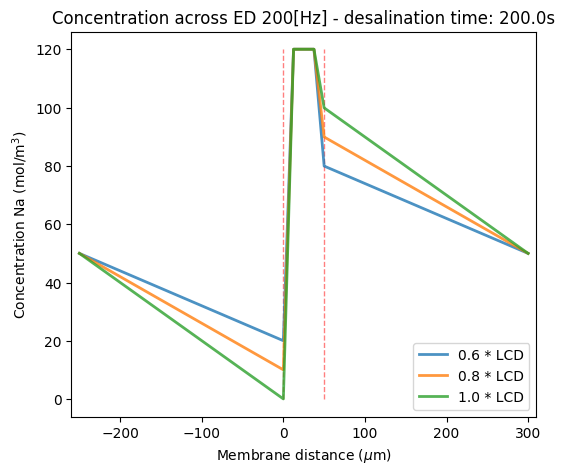

In [ ]:
#plotting x vs concentration at a fixed time

C=Conc[0]
x_list = [item * 1000000 for item in x_list]
t_freeze=20000
time=t_freeze*0.01
plt.figure(figsize = (6,5))
plt.ylabel("Concentration Na ($\mathregular{mol/m^3}$)")
plt.xlabel("Membrane distance ($\mu$m)")
plt.title(f"Concentration across ED 200[Hz] - desalination time: {time}s")
#plt.hlines(y=0.0, xmin=-260, xmax=310, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.vlines(x=d * 1000000, ymin=0, ymax=120, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.vlines(x=0.0, ymin=0, ymax=120, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.xlim(-260,310);

for i in range(N_eval):
    C = Conc[i]
    plt.plot(x_list[i],C, label=str(f"{round(lcd_mod[i],2)} * LCD"), linewidth=2, alpha = 0.8 ) #label=str(f"{lcd_mod[i]}*LCD")
    plt.legend(loc='lower right');

Min. concentration: (0.0, 20.061349885749976) (mol/m3)
Min. concentration: (0.0, 10.08179985071148) (mol/m3)
Min. concentration: (0.0, 0.10225020006032873) (mol/m3)


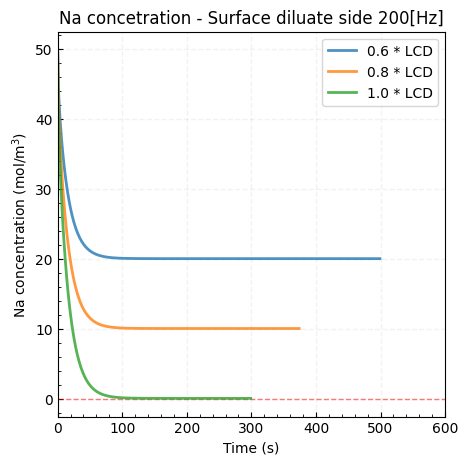

In [ ]:
#plotting concentration at different times in a fixed position (concentrate side)
plt.figure(figsize = (5,5))
plt.xlabel("Time (s)")
plt.ylabel("Na concentration ($\mathregular{mol/m^3}$)")
plt.minorticks_on()
plt.grid(color='black', ls = '--', lw = 1.0, alpha=0.05)
plt.tick_params(direction="in", which="both")
plt.title("Na concetration - Surface diluate side 200[Hz]")
plt.hlines(y=0.0, xmin=-10, xmax=650, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.xlim(-0,600)

Min_con = np.ones([N_eval])

for i in range(N_eval):
    fig = plt.plot(range(int(len(C_diluate[i]) )), C_diluate[i], label=str(f"{round(lcd_mod[i],2)} * LCD"), linewidth=2, alpha = 0.8)
    plt.legend(loc='upper right');
    Min_con[i] = (min(C_diluate[i]))
    print(f"Min. concentration: {Frequencies[i], min(C_diluate[i])} (mol/m3)")

In [ ]:
def values(t_on,t_rev,rev_amp, lcd_mod):
  #Evaluation of more than one value
  #First, define values to be evaluated. All arrays must have the same length
  Charge=16800.0 #Objective charge to be transported (As)

  lcd=56 #limiting current density (A/m2)
  iop=lcd_mod*lcd #Operational current density (A/m2)
  e_dc=(t_on-t_rev*(rev_amp))/(t_on+t_rev) #effective duty cycle
  print(f"eff. duty cycle: {e_dc} %")
  tsim=np.round(Charge/iop/e_dc,2)
  print(f"simulation time in minutes: {np.round(tsim/60,2)} min")
  print(f"simulation time in seconds: {np.round(tsim,2)} seg")
  Comp_Charge=np.round((tsim*iop*(t_on-rev_amp*t_rev)/(t_on+t_rev)),2)
  Comp_Charge

  Frequencies = 1/(t_on+t_rev)

  dt_print(t_on,t_rev,lcd_mod,rev_amp,tsim)

  print("frequencies:",Frequencies,"Hz")
  print("Charge:",Comp_Charge,"A*s")

  return Frequencies, tsim



In [ ]:
N_eval = 3 #Number of simulation

Energy_Consumption = [] #Energy consumption array

rev_amp_list = [ 1.0, 1.0, 1.0, 1.0, 1.0] #Reverse amplitud

duty_cycle = 0.6 #Effective duty cicle definition

lcd_mod_list = [ 1.0, 1.0, 1.0, 1.0, 1.0] #Currente density

tsim_list = [] #Simulation time array

freq = [0.1, 1.0 , 10.] # , 100, 1000] # Frequency array

t_on_list = []
t_rev_list = []

c_min_list = [] #Min concentration array

for i in range(N_eval):

  rev_amp = rev_amp_list[i] #Reverse amplitu definition

  lcd_mod = lcd_mod_list[i] #Current density definition

  t_on = (duty_cycle + rev_amp)/(freq[i] * (1 + rev_amp)) #T_on denfinition

  t_rev = (1/freq[i]) - t_on #T_rev definition

  #Append T_on and T_rev
  t_on_list.append(t_on)
  t_rev_list.append(t_rev)

  (f, tsim) = values(t_on,t_rev,rev_amp, lcd_mod_list[i]) #Frequency and simulation time definition

  tsim_list.append(tsim) #Append simulation time

  #Energy consumption, Min concentration, Diluate side concentration, time simulation and x vector definition
  [Ener, C_min,C_dil,ts,x]=funcion_ram(t_on,t_rev,lcd_mod,rev_amp,tsim)

  Energy_Consumption.append(Ener) #Append energy consumption
  c_min_list.append(min(C_dil)) #Append min concentration

eff. duty cycle: 0.6 %
simulation time in minutes: 8.33 min
simulation time in seconds: 500.0 seg
delta t:  0.01  Pasos:  50000.0
frequencies: 0.1 Hz
Charge: 16800.0 A*s
dt= 0.01
4.468
eff. duty cycle: 0.6000000000000001 %
simulation time in minutes: 8.33 min
simulation time in seconds: 500.0 seg
delta t:  0.01  Pasos:  50000.0
frequencies: 1.0 Hz
Charge: 16800.0 A*s
dt= 0.01
4.452
eff. duty cycle: 0.6 %
simulation time in minutes: 8.33 min
simulation time in seconds: 500.0 seg
delta t:  0.01  Pasos:  50000.0
frequencies: 10.0 Hz
Charge: 16800.0 A*s
dt= 0.01
4.462


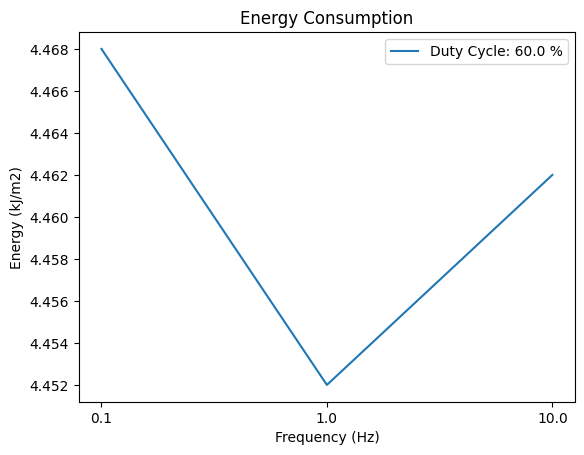

In [ ]:
#Polt parameters
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy (kJ/m2)")
plt.title("Energy Consumption")

x = range(N_eval) #Simulated frequency
plt.xticks(x,freq) #reshape x-axis

plt.plot(x,np.round(Energy_Consumption,0)/1000,label=str(f"Duty Cycle: {duty_cycle*100} %")) #Plot energy consumption
plt.legend(loc='upper right')

In [ ]:
malla = np.zeros(2 * I + Im + 2) #Aux variable for no uniform mesh definition

#Diluate side mesh definition
mesh_1 = left_DBL_beta(beta_mesh, I, alfa)

#Concentrate side mesh definition
mesh_2 = right_DBL_beta(beta_mesh, I, alfa)

#No uniform mesh definition
for i in range(2 * I + Im + 2):

  if i < I:
      malla[i] = mesh_1[i]

  elif i >= I and i < I + Im + 2:
      malla[i] = (i - I)*d / 4

  else:
      malla[i] = mesh_2[i - I - Im -2]

malla.sort()

print(len(malla))

n_elements = 2 * I + Im + 2 #Number of nodes

mesh = fe.IntervalMesh(n_elements-1,-dl, d + dl) #FeniCS mesh definition

x = np.linspace(-dl,dl+d,2*I+Im+2) #Postion vector

print(len(mesh.coordinates()[:]))

mesh.coordinates()[:] = np.reshape(malla,(n_elements,1)) #No uniform reshaped mesh


In [ ]:
#Double Diffusion Model

#Diffusion Constant

D1 = 1.33E-9 #Na constant diffusion
D2 = 2.03E-9  #Cl constant diffusion
D3 = 0.8E-9 #SDS constant diffusion

D1 = D

def Double_Diffusion(t_on,t_rev,lcd_mod,rev_amp,tsim):

  delta_t, pul, N, ts = ED_Model(t_on,t_rev,lcd_mod,rev_amp,tsim) #Δt, time simulation, number of iteration and puls definition

  malla = np.zeros(2 * I + Im + 2) #Aux variable for no uniform mesh definition

  #Diluate side mesh definition
  mesh_1 = left_DBL_beta(beta_mesh, I, alfa)

  #Concentrate side mesh definition
  mesh_2 = right_DBL_beta(beta_mesh, I, alfa)

  #No uniform mesh definition
  for i in range(2 * I + Im + 2):

    if i < I:
        malla[i] = mesh_1[i]

    elif i >= I and i < I + Im + 2:
        malla[i] = (i - I)*d / 4

    else:
        malla[i] = mesh_2[i - I - Im -2]

  malla.sort()

  n_elements = 2 * I + Im + 2 #Number of nodes

  mesh = fe.IntervalMesh(n_elements-1,-dl, d + dl) #FeniCS mesh definition

  x = np.linspace(-dl,dl+d,2*I+Im+2) #Postion vector

  mesh.coordinates()[:] = np.reshape(malla,(n_elements,1)) #No uniform reshaped mesh

  CG = fe.FunctionSpace(mesh, "CG", 1) #Function space

  Element1 = fe.FiniteElement("CG", mesh.ufl_cell(), 1) #Finite Element for Na concentration
  Element2 = fe.FiniteElement("CG", mesh.ufl_cell(), 1) #Finite Element for Cl concentration
  Element3 = fe.FiniteElement("CG", mesh.ufl_cell(), 1) #Finite Element for SDS concentration

  W_elem = fe.MixedElement([Element1, Element2, Element3]) #Mixed Element E1xE2xE3

  V = fe.FunctionSpace(mesh, W_elem) #Mixed function space definition

  BC1 = fe.DirichletBC(
    V.sub(0),
    fe.Constant(C0),
    left_boundary
      ) #Left DBL Na concentration boundary condition

  BC3 = fe.DirichletBC(
    V.sub(0),
    fe.Constant(C0),
    right_boundary
      ) #Right DBL Na concentration boundary condition

  BC_Cl1 = fe.DirichletBC(
    V.sub(1),
    fe.Constant(C0),
    left_boundary
      ) #Left DBL Cl concentration boundary condition

  BC_Cl2 = fe.DirichletBC(
    V.sub(1),
    fe.Constant(C0),
    right_boundary
      ) #Right DBL Cl concentration boundary condition

  BC_SDS1 = fe.DirichletBC(
    V.sub(2),
    fe.Constant(C0*0.1),
    left_boundary
      ) #Left SDS Na concentration boundary condition

  BC_SDS2 = fe.DirichletBC(
    V.sub(2),
    fe.Constant(C0*0.1),
    Boundary_SDS
      ) #Right SDS Na concentration boundary condition

  BCS = [BC1,BC3,BC_Cl1,BC_Cl2,BC_SDS1,BC_SDS2]	#Boundary conditions

  #Gradient condition interpolation
  deriv_ = fe.Function(CG)
  deriv_.interpolate(Derivada_(degree = 2))

  #Na transport number interpolation
  T_Na = fe.Function(CG)
  T_Na.interpolate(TNa(degree = 2))

  #SDS transport number interpolation
  T_SDS = fe.Function(CG)
  T_SDS.interpolate(TSds(degree = 2))

  #Cl transport number interpolation
  T_Cl = fe.Function(CG)
  T_Cl.interpolate(TCl(degree = 2))

  c_01 = fe.interpolate(fe.Expression('CM', CM = C0, degree = 1), CG) #Intial Na concentration
  c_02 = fe.interpolate(fe.Expression('CM', CM = C0, degree = 1), CG) #Intial Cl concentration
  c_03 = fe.interpolate(fe.Expression('CM', CM = C0*0.1, degree = 1), CG) #Intial SDS concentration

  (c_1, c_2,c_3) = fe.TrialFunction(V) #Trial function definition
  (v_1, v_2,v_3) = fe.TestFunction(V) #Test function definition

  iop = pul[0] #Initial puls definition

  #Constant puls function interpolation
  g = fe.Expression('iop', iop = iop, degree = 1)
  i_t = fe.Function(CG)
  i_t.interpolate(g)

  a_Na = (
  + c_1 * v_1 * fe.dx
  + delta_t * D1 * c_1.dx(0) * v_1 * fe.ds
  + deriv_ * delta_t * D1 * c_1.dx(0) * v_1.dx(0) * fe.dx
  ) #Na bilinear form definition

  L_Na = (
  + c_01 * v_1 * fe.dx
  + delta_t * i_t * T_Na * v_1.dx(0) / (z_Na * F) * fe.dx
  + delta_t * i_t * T_Na_d * v_1 / (z_Na * F) * fe.ds
  ) #Na linear form definition

  a_Cl = (
  + c_2 * v_2 * fe.dx
  + delta_t * D2 * c_2.dx(0) * v_2 * fe.ds
  + deriv_ * delta_t * D2 * c_2.dx(0) * v_2.dx(0) * fe.dx
  ) #Cl bilinear form definition

  L_Cl = (
  + c_02 * v_2 * fe.dx
  - delta_t * i_t * T_Cl * v_2.dx(0) / (z_Cl * F) * fe.dx
  ) #Cl linear form definition

  a_Sds = (
  + c_3 * v_3 * fe.dx
  + delta_t * D3 * c_3.dx(0) * v_3 * fe.ds
  + deriv_ * delta_t * D3 * c_3.dx(0) * v_3.dx(0) * fe.dx
  ) #SDS bilinear form definition

  L_Sds = (
  + c_03 * v_3 * fe.dx
  - delta_t * i_t * T_SDS * v_3.dx(0) / (z_Cl * F) * fe.dx
  ) #SDS linear form definition


  a = a_Na + a_Cl + a_Sds #Bilinear form definition

  L = L_Na + L_Cl + L_Sds #Linear form definition

  #Mesh nodes definition
  xyz = CG.tabulate_dof_coordinates()
  x = xyz[:,0]

  c_solution = fe.Function(V) #Aux solution function

  time_current = 0 #Initial current time

  A = fe.assemble(a) #Assemble bilinear form
  [bc.apply(A) for bc in BCS] #Apply each boundary condition
  solver = fe.LUSolver(A) #Solver definition

  indices = []

  sol_Na = fe.Function(CG) #Na solution function
  sol_Cl = fe.Function(CG) #Cl solution function
  sol_SDS = fe.Function(CG) #SDS solution function

  #Function assigner for each finite element
  fa_1= fe.FunctionAssigner(CG,V.sub(0))
  fa_2= fe.FunctionAssigner(CG,V.sub(1))
  fa_3= fe.FunctionAssigner(CG,V.sub(2))

  #Membrane nodes
  for i in range(len(x)):

    if x[i] > 0 and x[i] < d:

      indices.append(i)

  C_Na = np.zeros([2*I + Im +2,int(tsim)]) #Na soltution array
  C_min_Na=[]

  C_Cl = np.zeros([2*I + Im +2,int(tsim)]) #Cl soltution array
  C_min_Cl=[]

  C_SDS = np.zeros([2*I + Im +2,int(tsim)]) #SDS soltution array
  C_min_SDS=[]

  for i in range(0,N-1):

    iop = pul[i] #Puls value for spet i

    #Puls function interpolation
    g = fe.Expression('iop', iop = iop, degree = 1)
    i_t.interpolate(g)

    #Assemble the RHS
    b = fe.assemble(L)

    #Axpply BCs
    [bc.apply(b) for bc in BCS]

    solver.solve(c_solution.vector(),b) #Apply solver

    (c_s1, c_s2, c_s3) = c_solution.split() #Solution split

    #Apply each function assigner to aux and solution function
    fa_1.assign(c_01,c_s1)
    fa_1.assign(sol_Na,c_s1)
    fa_2.assign(c_02,c_s2)
    fa_2.assign(sol_Cl, c_s2)
    fa_3.assign(c_03,c_s3)
    fa_3.assign(sol_SDS, c_s3)

    #Apply membrane condition
    for j in indices:

      sol_Na.vector()[j] = Cmem
      sol_Cl.vector()[j] = Cmem
      sol_SDS.vector()[j] = 0

    #Time step condition
    if i % int(1/delta_t) == 0:

      C_Na[:,int(i*delta_t)] = sol_Na.vector().get_local() #Get Na concentration value

      C_Cl[:,int(i*delta_t)] = sol_Cl.vector().get_local() #Get Cl concentration value

      C_SDS[:,int(i*delta_t)]= sol_SDS.vector().get_local() #Get SDS concentration value

      #Get concentration value surface diluate side
      C_min_Na.append(C_Na[:,int(i*delta_t)][indices[-1]+1])
      C_min_Cl.append(C_Cl[:,int(i*delta_t)][indices[-1]+1])
      C_min_SDS.append(C_SDS[:,int(i*delta_t)][indices[-1]+1])

    #Print step
    #if i % int(1/delta_t) == 0:
      #print("Paso: ", round(time_current,0))

    time_current += delta_t #Time current update

  return C_min_Na, C_min_Cl, C_min_SDS,ts

In [ ]:
#Evaluation of more than one value
#First, define values to be evaluated. All arrays must have the same length
Charge=16800.0 #Objective charge to be transported (As)

N_eval=3

lcd_mod=np.array([0.6, 0.8, 1])
rev_amp=np.ones([N_eval]) * 1.0

t_on=np.ones([N_eval]) * 100
t_rev=np.ones([N_eval])* 0.0

lcd=56 #limiting current density (A/m2)

iop=lcd_mod*lcd #Operational current density (A/m2)

e_dc=(t_on-t_rev*(rev_amp))/(t_on+t_rev) #effective duty cycle

tsim=np.round(Charge/iop/e_dc,2) #Simulation time

#Transported charge (As)
Comp_Charge=np.round((tsim*iop*(t_on-rev_amp*t_rev)/(t_on+t_rev)),2)
Comp_Charge

print(f"eff. duty cycle: {e_dc} %")
print(f"simulation time in minutes: {np.round(tsim/60,2)} min")
print(f"simulation time in seconds: {np.round(tsim,2)} seg")


Frequencies =np.ones([N_eval])*1.0 #Frequency definition

for k in range(len(t_rev)):
  if t_rev[k] == 0.0:
    Frequencies[k]=0*t_rev[k]
  else:
      Frequencies[k]=1/(t_on[k]+t_rev[k])

for k in range(N_eval):
    dt_print(t_on[k],t_rev[k],lcd_mod[k],rev_amp[k],tsim[k] )

print("frequencies:",Frequencies,"Hz")
print("Charge:",Comp_Charge,"A*s")

eff. duty cycle: [1. 1. 1.] %
simulation time in minutes: [8.33 6.25 5.  ] min
simulation time in seconds: [500. 375. 300.] seg
delta t:  0.01  Pasos:  50000.0
delta t:  0.01  Pasos:  37500.0
delta t:  0.01  Pasos:  30000.0
frequencies: [0. 0. 0.] Hz
Charge: [16800. 16800. 16800.] A*s


In [ ]:
#Evaluate and save the summary results in a list

C_min_sodio=[] #Na concentration array
C_min_cloro=[] #Cl concentration array
C_min_FOULING = [] #SDS concentration array

ts_mod = []
con_min_na = []
con_min_sds = []

for k in range(N_eval):
    [C_min_Na, C_min_Cl, C_min_SDS ,ts]=Double_Diffusion(t_on[k],t_rev[k],lcd_mod[k],rev_amp[k],tsim[k])
    print("Finished computing combination",k+1,"of",N_eval)
    C_min_sodio.append(C_min_Na)
    ts_mod.append(ts)
    C_min_FOULING.append(C_min_SDS)
    C_min_cloro.append(C_min_Cl)
    con_min_sds.append(max(C_min_SDS))
    con_min_na.append(min(C_min_Na))

dt= 0.01
Finished computing combination 1 of 3
dt= 0.01
Finished computing combination 2 of 3
dt= 0.01
Finished computing combination 3 of 3


Min. concentration: (0.0, 70.73018616928205) (mol/m3)
Min. concentration: (0.0, 20.061349885749998) (mol/m3)
Min. concentration: (0.0, 92.63951816671035) (mol/m3)
Min. concentration: (0.0, 10.08179985071148) (mol/m3)
Min. concentration: (0.0, 114.54101178621848) (mol/m3)
Min. concentration: (0.0, 0.10225020006032873) (mol/m3)


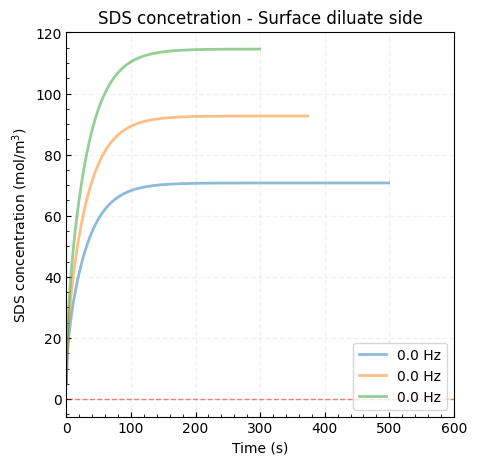

In [ ]:
#plotting concentration at different times in a fixed position (concentrate side)
plt.figure(figsize = (5,5))
plt.xlabel("Time (s)")
plt.ylabel("SDS concentration ($\mathregular{mol/m^3}$)")
plt.minorticks_on()
plt.grid(color='black', ls = '--', lw = 1.0, alpha=0.05)
plt.tick_params(direction="in", which="both")
plt.title("SDS concetration - Surface diluate side")
plt.hlines(y=0.0, xmin=-10, xmax=650, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.xlim(-0,600)

color = ['b', 'g', 'r', 'y', 'm']

Min_con = np.ones([N_eval])

for i in range(N_eval):
    fig = plt.plot(range(int(len(C_min_sodio[i]))), C_min_FOULING[i] , label=str(f"{round(Frequencies[i],2)} Hz"), linewidth=2, alpha = 0.5)
    plt.legend(loc='lower right');
    Min_con[i] = (min(C_min_cloro[i]))
    print(f"Min. concentration: {Frequencies[i], C_min_FOULING[i][-1]} (mol/m3)")
    print(f"Min. concentration: {Frequencies[i], C_min_sodio[i][-1]} (mol/m3)")

Min. concentration: (0.0, 70.73018616928205) (mol/m3)
Min. concentration: (0.0, 20.061349885749998) (mol/m3)
Min. concentration: (0.0, 92.63951816671035) (mol/m3)
Min. concentration: (0.0, 10.08179985071148) (mol/m3)
Min. concentration: (0.0, 114.54101178621848) (mol/m3)
Min. concentration: (0.0, 0.10225020006032873) (mol/m3)


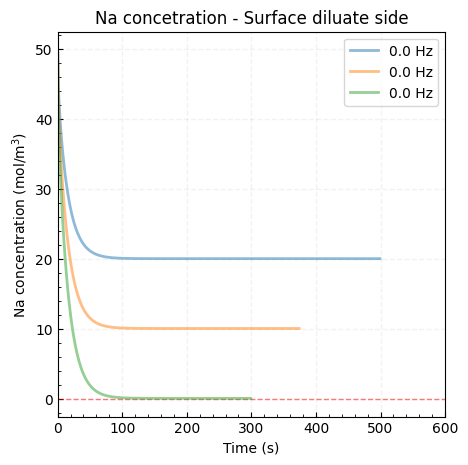

In [ ]:
#plotting concentration at different times in a fixed position (concentrate side)
plt.figure(figsize = (5,5))
plt.xlabel("Time (s)")
plt.ylabel("Na concentration ($\mathregular{mol/m^3}$)")
plt.minorticks_on()
plt.grid(color='black', ls = '--', lw = 1.0, alpha=0.05)
plt.tick_params(direction="in", which="both")
plt.title("Na concetration - Surface diluate side")
plt.hlines(y=0.0, xmin=-10, xmax=650, linewidth=1, color='r', ls = '--', alpha = 0.5)
plt.xlim(-0,600)

color = ['b', 'g', 'r', 'y', 'm']

Min_con = np.ones([N_eval])

for i in range(N_eval):
    fig = plt.plot(range(int(len(C_min_sodio[i]))), C_min_sodio[i], label=str(f"{round(Frequencies[i],2)} Hz") , linewidth=2, alpha = 0.5)
    plt.legend(loc='upper right');
    Min_con[i] = (min(C_min_cloro[i]))
    print(f"Min. concentration: {Frequencies[i], C_min_FOULING[i][-1]} (mol/m3)")
    print(f"Min. concentration: {Frequencies[i], C_min_sodio[i][-1]} (mol/m3)")